~~~
Copyright 2026 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Chest X-ray longitudinal comparison with MedGemma 1.5

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/cxr_longitudinal_comparison_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogle-Health%2Fmedgemma%2Fmain%2Fnotebooks%2Fcxr_longitudinal_comparison_with_hugging_face.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/cxr_longitudinal_comparison_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates how to perform longitudinal comparison of chest X-ray (CXR) images with <a href='https://developers.google.com/health-ai-developer-foundations/medgemma'>MedGemma</a> 1.5 using Hugging Face libraries. This notebook is for educational purposes only to show the baseline functionality of MedGemma 1.5. It does not represent a finished or approved product, is not intended to diagnose or suggest treatment for any disease or condition, and should not be used for medical advice. See HAI-DEF <a href='https://developers.google.com/health-ai-developer-foundations/terms?'>Terms of Use</a> for more information.

## Setup

To complete this tutorial, you'll need to have a runtime with [sufficient resources](https://ai.google.dev/gemma/docs/core#sizes) to run the MedGemma model.

You can try out MedGemma 4B for free in Google Colab using a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Get access to MedGemma

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-1.5-4b-it) and accept the usage conditions.

### Authenticate with Hugging Face

Generate a Hugging Face `read` access token by going to [settings](https://huggingface.co/settings/tokens).

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [ ]:
import os
import sys

google_colab = "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT")

if google_colab:
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

### Install dependencies

In [ ]:
! pip install --upgrade --quiet accelerate transformers

## Load model from Hugging Face Hub

In [ ]:
from transformers import pipeline
import torch

model_id = "google/medgemma-1.5-4b-it"
model_kwargs = dict(
    dtype=torch.bfloat16,
    device_map="auto",
)

pipe = pipeline("image-text-to-text", model=model_id, model_kwargs=model_kwargs)

pipe.model.generation_config.do_sample = False


## Run inference

### Specify image and text inputs

In [ ]:
import os
from PIL import Image

prompt = f"""Provide a comparison of these two images and include details from
the image which students should take note of when reading longitudinal CXR
"""

# Image attribution: Stillwaterising, CC0, via Wikimedia Commons
image1_url = "https://storage.googleapis.com/hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/longitudinal_cxr_before.png"  # @param {type: "string"}
# Image generated by Gemini and reviewed by in-house board certified radiologist
image2_url = "https://storage.googleapis.com/hai-cd3-foundations-public-vault-entry/med_gemma/colab_example/cxr/longitudinal_cxr_after.png"  # @param {type: "string"}
! wget -nc -q {image1_url} {image2_url}
image_filename1 = os.path.basename(image1_url)
image_filename2 = os.path.basename(image2_url)
image1 = Image.open(image_filename1)
image2 = Image.open(image_filename2)

### Preprocess image

Pad the input image to a square format. This maintains consistency with the original preprocessing in model training and evaluation.


In [ ]:
import numpy as np
import skimage


def pad_image_to_square(image_array):
    # Convert image to unsigned byte format and handle grayscale/RGBA images.
    image_array = skimage.util.img_as_ubyte(image_array)
    if len(image_array.shape) < 3:
        image_array = skimage.color.gray2rgb(image_array)
    if image_array.shape[2] == 4:
        image_array = skimage.color.rgba2rgb(image_array)

    # Pad the image to a square shape.
    h = image_array.shape[0]
    w = image_array.shape[1]
    max_dim = max(h, w)
    if h < w:
        dh = w - h
        image_array = np.pad(
            image_array, ((dh // 2, dh - dh // 2), (0, 0), (0, 0))
        )
    if w < h:
        dw = h - w
        image_array = np.pad(
            image_array, ((0, 0), (dw // 2, dw - dw // 2), (0, 0))
        )
    return image_array


preprocess_image = False  # @param {type: "boolean"}

if preprocess_image:
    # Convert the input image to a square numpy array and normalize pixel values.
    image_array1 = (pad_image_to_square(image1) * 255).astype(np.uint8)
    # Convert the numpy array back to a PIL Image.
    image1 = Image.fromarray(image_array1)
    # Convert the input image to a square numpy array and normalize pixel values.
    image_array2 = (pad_image_to_square(image2) * 255).astype(np.uint8)
    # Convert the numpy array back to a PIL Image.
    image2 = Image.fromarray(image_array2)

### Run model with the `pipeline` API

---

**[ User ]**

Provide a comparison of these two images and include details from
the image which students should take note of when reading longitudinal CXR


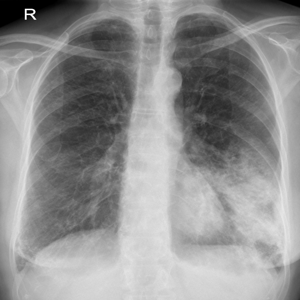

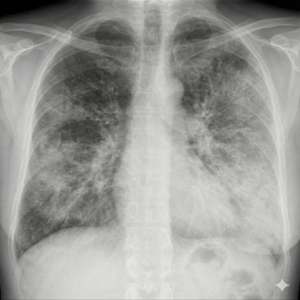

---

**[ MedGemma ]**

Okay, here's a comparison of the two chest X-rays, highlighting key features students should pay attention to when interpreting longitudinal studies.

**Image 1 (Left):**

*   **Overall Appearance:** There is a significant opacity (whiteness) in the lower left lung field.
*   **Pattern:** The opacity is somewhat patchy and suggests a consolidation or infiltration. There might be some associated atelectasis (lung collapse) in the affected area.
*   **Other Findings:** The right lung appears relatively clear, although there are some interstitial markings.

**Image 2 (Right):**

*   **Overall Appearance:** There is widespread, diffuse, and more pronounced opacity throughout both lungs. The pattern is less localized and more diffuse.
*   **Pattern:** The infiltrates are more homogenous and widespread than in the left image.
*   **Other Findings:** The right lung also shows some interstitial markings.

**Comparison and Key Takeaways:**

1.  **Location:** In the first image, the opacity is primarily in the lower left lung. In the second image, the opacity is more diffuse and affects both lungs.
2.  **Density:** The opacity in the first image is relatively dense and localized. The opacity in the second image is more diffuse and less dense.
3.  **Consistency:** The opacity in the first image is more patchy, while in the second image it is more homogenous.

**Important Considerations for Students:**

*   **Clinical Context:** The interpretation of any chest X-ray must always be done in the context of the patient's clinical history, symptoms, and other investigations.
*   **Comparison over Time:** When looking at a series of chest X-rays taken over time, it is crucial to compare the images to identify changes in the pattern, density, and location of abnormalities.
*   **Differential Diagnosis:** A chest X-ray can provide clues to various conditions, including pneumonia, pulmonary edema, tuberculosis, and malignancy. The pattern of findings helps narrow down the possibilities.
*   **Image Quality:** Ensure the images are properly labeled and the technique (e.g., inspiration, PA view) is consistent.

The two images show different patterns of lung abnormalities. The first image shows a localized consolidation in the left lower lung, while the second image shows diffuse infiltrates throughout both lungs. Both images could potentially indicate different underlying pathologies. It is essential to correlate the findings with the patient's clinical presentation and other diagnostic tests.

---

'This notebook is not a medical device, may contain inaccuracies, and should not be used for medical purposes.'

In [ ]:
from IPython.display import display, Markdown

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image1},
            {"type": "image", "image": image2},
            {"type": "text", "text": prompt}
        ]
    }
]

output = pipe(text=messages, max_new_tokens=600)
response = output[0]["generated_text"][-1]["content"]

display(Markdown(f"---\n\n**[ User ]**\n\n{prompt}"))
display(image1.resize((300, 300)))
display(image2.resize((300, 300)))
display(Markdown(f"---\n\n**[ MedGemma ]**\n\n{response}\n\n---"))
display("This notebook is not a medical device, may contain inaccuracies, and should not be used for medical purposes.")

## Next steps

Explore the other [notebooks](https://github.com/google-health/medgemma/blob/main/notebooks) to learn what else you can do with the model.